![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from French to English.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](http://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a single vector, and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

# The Sequence to Sequence model

A [Sequence to Sequence network](http://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![](https://i.imgur.com/tVtHhNp.png)

When using a single RNN, there is a one-to-one relationship between inputs and outputs. We would quickly run into problems with different sequence orders and lengths that are common during translation. Consider the simple sentence "Je ne suis pas le chat noir" &rarr; "I am not the black cat". Many of the words have a pretty direct translation, like "chat" &rarr; "cat". However the differing grammars cause words to be in different orders, e.g. "chat noir" and "black cat". There is also the "ne ... pas" &rarr; "not" construction that makes the two sentences have different lengths.

With the seq2seq model, by encoding many inputs into one vector, and decoding from one vector into many outputs, we are freed from the constraints of sequence order and length. The encoded sequence is represented by a single vector, a single point in some N dimensional space of sequences. In an ideal case, this point can be considered the "meaning" of the sequence.

This idea can be extended beyond sequences. Image captioning tasks take an [image as input, and output a description](https://arxiv.org/abs/1411.4555) of the image (img2seq). Some image generation tasks take a [description as input and output a generated image](https://arxiv.org/abs/1511.02793) (seq2img). These models can be referred to more generally as "encoder decoder" networks.

## The Attention Mechanism

The fixed-length vector carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

The **attention mechanism** [introduced by Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![](https://i.imgur.com/5y6SCvU.png)

Attention is calculated with another feedforward layer in the decoder. This layer will use the current input and hidden state to create a new vector, which is the same size as the input sequence (in practice, a fixed maximum length). This vector is processed through softmax to create *attention weights*, which are multiplied by the encoders' outputs to create a new context vector, which is then used to predict the next output.

![](https://i.imgur.com/K1qMPxs.png)

# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later.

If you haven't already, look through some of the [Recommended Reading](https://github.com/spro/practical-pytorch/#recommended-reading) for this series.

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [2]:
USE_CUDA = True

# Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site http://tatoeba.org/ which has downloads available at http://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download `fra-eng.zip`, extract the text file in there, and rename it to `data/eng-fra.txt` before continuing (for some reason the zipfile is named backwards). The file is a tab separated list of translation pairs:

```
I am cold.    Je suis froid.
```

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Reading and decoding files

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English &rarr; Other Language, so if we want to translate from Other Language &rarr; English I added the `reverse` flag to reverse the pairs.

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

### Filtering sentences

Since there are a *lot* of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes being removed).

In [6]:
MAX_LENGTH = 10

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(good_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 9129 sentence pairs
Counting words...
fra 3925
eng 2696
['il est tres en colere .', 'he is very angry .']


## Turning training data into Tensors/Variables

To train we need to turn the sentences into something the neural network can understand, which of course means numbers. Each sentence will be split into words and turned into a Tensor, where each word is replaced with the index (from the Lang indexes made earlier). While creating these tensors we will also append the EOS token to signal that the sentence is over.

![](https://i.imgur.com/LzocpGH.png)

A Tensor is a multi-dimensional array of numbers, defined with some type e.g. FloatTensor or LongTensor. In this case we'll be using LongTensor to represent an array of integer indexes.

Trainable PyTorch modules take Variables as input, rather than plain Tensors. A Variable is basically a Tensor that is able to keep track of the graph state, which is what makes autograd (automatic calculation of backwards gradients) possible.

In [8]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Building the models

## The Encoder

<img src="images/encoder-network.png" style="float: right" />

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

We can test the encoder model with a word input and an initial hidden state $h_0$ (created with `init_hidden()`)

In [10]:
encoder_test = EncoderRNN(10, 10, 2)
print(encoder_test)

encoder_hidden = encoder_test.init_hidden()
word = Variable(torch.LongTensor([1]))
if USE_CUDA:
    encoder_test.cuda()
    word = word.cuda()
out, hidden = encoder_test(word, encoder_hidden)
print(out.size(), hidden.size())

EncoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
torch.Size([1, 1, 10]) torch.Size([2, 1, 10])


## Attention Decoder

Calculating the attention weights is done with a feed-forward layer `attn`, using the decoder's input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to specify a maximum sentence length. Sentences of the maximum length will use all weights, while shorter sentences will only use the first few.

![](images/attention-decoder-network.png)

Note that we're also passing an unused `context` vector in `forward()` - this allows you to try models that make more use of the context vector by applying it at every step. In this implementation the context is only used to initialize the decoder's hidden state.

In [1]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define the layers
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, context, encoder_outputs):
        # Get the embedding of the current input word
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # Combine embedding and hidden state, run through attention layer
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))

        # Multiply attention weights over encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        # Combine embedding with attention output, run that through another layer, apply dropout
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        # Apply GRU to the output so far
        output, hidden = self.gru(output, hidden)

        # Apply log softmax to output
        output = F.log_softmax(self.out(output[0]))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

# Training

## Defining a training cycle

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

### Teacher Forcing and Scheduled Sampling

"Teacher Forcing", or maximum likelihood sampling, means using the real target outputs as each next input when training. The alternative is using the decoder's own guess as the next input. Using teacher forcing may cause the network to converge faster, but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - you could think of it as having learned how to listen to the teacher's instructions, without learning how to venture out on its own.

The solution to the teacher-forcing "problem" is known as [Scheduled Sampling](https://arxiv.org/abs/1506.03099), which simply alternates between using the target values and predicted values when training. We will randomly choose to use teacher forcing with an if statement while training - sometimes we'll feed use real target as the input (ignoring the decoder's output), sometimes we'll use the decoder's output.

In [12]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    # Prepare input and output variables
    encoder_hidden = encoder.init_hidden()
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    if USE_CUDA:
        encoder_outputs = encoder_outputs.cuda()
        decoder_input = decoder_input.cuda()

    # Run words through encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    # Copy last hidden state from encoder as decoder's first hidden state
    decoder_hidden = encoder_hidden

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    
    if use_teacher_forcing:
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output[0], target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

Finally helper functions to print time elapsed and estimated time remaining, given the current time and progress.

In [13]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, and loss function (criterion):

In [31]:
# Initialize models (comment out to continue training)
hidden_size = 250
n_layers = 2
dropout_p = 0.05
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Then set up variables for plotting and tracking progress:

In [32]:
# Configuring training
n_epochs = 75000
plot_every = 100
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. You can comment out the lines where the encoder and decoder are defined (so they aren't reinitialized) or simply run the notebook from the below cell.

In [33]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 32s (- 39m 57s) (1000 1%) 3.2960
1m 5s (- 39m 35s) (2000 2%) 2.7878
1m 38s (- 39m 17s) (3000 4%) 2.6247
2m 11s (- 38m 49s) (4000 5%) 2.5031
2m 44s (- 38m 17s) (5000 6%) 2.3907
3m 17s (- 37m 49s) (6000 8%) 2.3141
3m 50s (- 37m 17s) (7000 9%) 2.1637
4m 23s (- 36m 43s) (8000 10%) 2.0696
4m 56s (- 36m 11s) (9000 12%) 2.0656
5m 29s (- 35m 38s) (10000 13%) 1.9549
6m 2s (- 35m 7s) (11000 14%) 1.8973
6m 35s (- 34m 34s) (12000 16%) 1.8898
7m 8s (- 34m 1s) (13000 17%) 1.8007
7m 41s (- 33m 29s) (14000 18%) 1.8365
8m 14s (- 32m 59s) (15000 20%) 1.7545
8m 48s (- 32m 28s) (16000 21%) 1.6208
9m 21s (- 31m 56s) (17000 22%) 1.6913
9m 54s (- 31m 23s) (18000 24%) 1.6289
10m 28s (- 30m 51s) (19000 25%) 1.5844
11m 1s (- 30m 20s) (20000 26%) 1.5254
11m 34s (- 29m 46s) (21000 28%) 1.5006
12m 8s (- 29m 14s) (22000 29%) 1.4647
12m 41s (- 28m 41s) (23000 30%) 1.4306
13m 14s (- 28m 8s) (24000 32%) 1.3832
13m 47s (- 27m 35s) (25000 33%) 1.3438
14m 20s (- 27m 2s) (26000 34%) 1.3928
14m 54s (- 26m 29s) (27000 36

## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

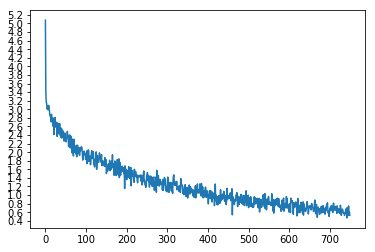

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [35]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.init_hidden()
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    if USE_CUDA: encoder_outputs = encoder_outputs.cuda()
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    if USE_CUDA: decoder_input = decoder_input.cuda()
    #decoder_hidden = decoder.init_hidden()
    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [36]:
def evaluate_randomly(n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention = evaluate(pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [37]:
evaluate_randomly()

> vous n etes qu un lache .
= you re nothing but a coward .
< you re nothing but a coward . <EOS>

> je ne te donnerai aucun argent .
= i m not giving you any money .
< i m not giving you any money . <EOS>

> il est sur le point de mourir .
= he is about to die .
< he is about to die . <EOS>

> je t ordonne de partir immediatement .
= i m ordering you to leave immediately .
< i m afraid you to leave leave immediately . <EOS>

> je suis fauche .
= i m broke .
< i m broke . <EOS>

> vous etes plus grands que moi .
= you are taller than me .
< you re taller than me . <EOS>

> j ai toujours soif .
= i m still thirsty .
< i m always thirsty . <EOS>

> j aurai besoin de ton aide .
= i m going to need your help .
< i m going to need your help . <EOS>

> je suis heureux que vous soyez la .
= i m happy you re here .
< i m glad you re here . <EOS>

> je vais etre votre institutrice .
= i m going to be your teacher .
< i m going to be your teacher . <EOS>



# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

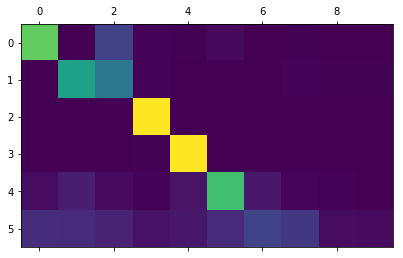

In [38]:
output_words, attentions = evaluate("je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [39]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


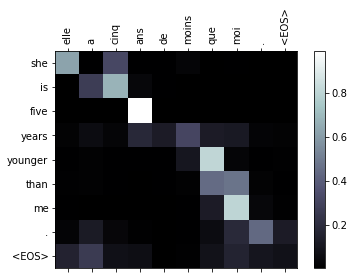

In [40]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .")

input = elle est trop petit .
output = she is too short . <EOS>


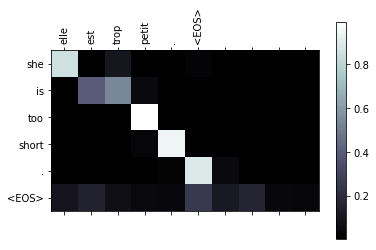

In [41]:
evaluate_and_show_attention("elle est trop petit .")

input = je ne crains pas de mourir .
output = i m not afraid of dying . <EOS>


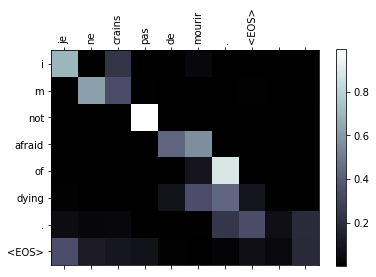

In [42]:
evaluate_and_show_attention("je ne crains pas de mourir .")

input = c est un jeune directeur plein de talent .
output = he s a young young woman . <EOS>


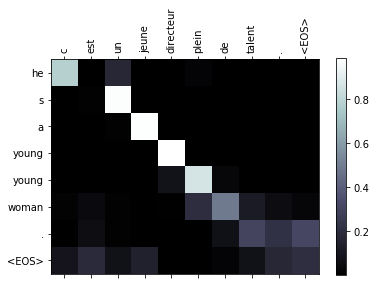

In [43]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")

# Exercises

* Try with a different dataset
    * Another language pair
    * Human &rarr; Machine (e.g. IOT commands)
    * Chat &rarr; Response
    * Question &rarr; Answer
* Replace the embedding pre-trained word embeddings such as word2vec or GloVe
* Try with more layers, more hidden units, and more sentences. Compare the training time and results.
* If you use a translation file where pairs have two of the same phrase (`I am test \t I am test`), you can use this as an autoencoder. Try this:
    * Train as an autoencoder
    * Save only the Encoder network
    * Train a new Decoder for translation from there